## Capstone 2: Data Wrangling


### Update 11/6 
### Doing a smaller version first , specifically focused on Clayton Kershaw in 2015
### In a given at bat, what pitch is coming next?

### Overview

How can we use data from 2015-2018 to predict/assess what type of pitch should be thrown in a given at bat?

This can be looked at from both the pitching team’s perspective (what is the ideal pitch for a given situation), and from the batting team (what pitch should I expect, assuming that the pitcher will choose the optimal pitch). Using the ab_id, we can link the data in the pitches csv to the data in the atbats csv to look at the outcomes of at bats along with the exact type and order of pitches thrown. We can add to this by using the batter_id and pitcher_id to gather specific data for a given hitter or pitcher by linking with the player_names csv. 

The data will be acquired from https://www.kaggle.com/pschale/mlb-pitch-data-20152018?select=pitches.csv
which was scraped from  http://gd2.mlb.com/components/game/mlb/.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas_profiling
from library.sb_utils import save_file
%matplotlib inline

In [91]:
from pathlib import Path
import pandas_profiling
import requests
from pandas_profiling.utils.cache import cache_file
from pandas_profiling import ProfileReport

In [2]:
import datetime as dt
from datetime import datetime

### Because I found myself repeatedly using this technique, I decided to define the following function to show missing values

In [3]:
#missing values function
def missing(df):
    '''Takes dataframe as argument, 
    returns count and % of missing values for each column'''
    import pandas as pd
    miss = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis = 1)
    miss.columns = ['count','%']
    return miss.sort_values(by = ['count'], ascending = False)

### Import the data
#### First we will do a small file (player_names), and then do the rest

In [4]:
#the CSV data files are in the data/raw directory
#player names
names = pd.read_csv('../data/raw/player_names.csv')

In [5]:
names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          2218 non-null   int64 
 1   first_name  2218 non-null   object
 2   last_name   2218 non-null   object
dtypes: int64(1), object(2)
memory usage: 52.1+ KB


In [6]:
names.head()

,id,first_name,last_name
0,452657,Jon,Lester
1,425794,Adam,Wainwright
2,457435,Phil,Coke
3,435400,Jason,Motte
4,519166,Neil,Ramirez


## Import Games and At-Bats Data

In [7]:
#the CSV data files are in the data/raw directory
#at bat info
atbats = pd.read_csv('../data/raw/atbats.csv')
#games info 
games = pd.read_csv('../data/raw/games.csv')


In [8]:
atbats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740389 entries, 0 to 740388
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ab_id       740389 non-null  int64 
 1   batter_id   740389 non-null  int64 
 2   event       740389 non-null  object
 3   g_id        740389 non-null  int64 
 4   inning      740389 non-null  int64 
 5   o           740389 non-null  int64 
 6   p_score     740389 non-null  int64 
 7   p_throws    740389 non-null  object
 8   pitcher_id  740389 non-null  int64 
 9   stand       740389 non-null  object
 10  top         740389 non-null  bool  
dtypes: bool(1), int64(7), object(3)
memory usage: 57.2+ MB


In [9]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9718 entries, 0 to 9717
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   attendance        9718 non-null   int64 
 1   away_final_score  9718 non-null   int64 
 2   away_team         9718 non-null   object
 3   date              9718 non-null   object
 4   elapsed_time      9718 non-null   int64 
 5   g_id              9718 non-null   int64 
 6   home_final_score  9718 non-null   int64 
 7   home_team         9718 non-null   object
 8   start_time        9718 non-null   object
 9   umpire_1B         9718 non-null   object
 10  umpire_2B         9715 non-null   object
 11  umpire_3B         9718 non-null   object
 12  umpire_HP         9718 non-null   object
 13  venue_name        9718 non-null   object
 14  weather           9718 non-null   object
 15  wind              9718 non-null   object
 16  delay             9718 non-null   int64 
dtypes: int64(6), o

## Import Pitch Data (800 mb)

In [10]:
#the CSV data files are in the data/raw directory
pitches = pd.read_csv('../data/raw/pitches.csv')

In [11]:
pitches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2867154 entries, 0 to 2867153
Data columns (total 40 columns):
 #   Column           Dtype  
---  ------           -----  
 0   px               float64
 1   pz               float64
 2   start_speed      float64
 3   end_speed        float64
 4   spin_rate        float64
 5   spin_dir         float64
 6   break_angle      float64
 7   break_length     float64
 8   break_y          float64
 9   ax               float64
 10  ay               float64
 11  az               float64
 12  sz_bot           float64
 13  sz_top           float64
 14  type_confidence  float64
 15  vx0              float64
 16  vy0              float64
 17  vz0              float64
 18  x                float64
 19  x0               float64
 20  y                float64
 21  y0               float64
 22  z0               float64
 23  pfx_x            float64
 24  pfx_z            float64
 25  nasty            float64
 26  zone             float64
 27  code        

In [12]:
pitches.head()

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,event_num,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,0.416,2.963,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665,...,3,0.0,2.015000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.191,2.347,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043,...,4,0.0,2.015000e+09,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2,-0.518,3.284,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368,...,5,0.0,2.015000e+09,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,-0.641,1.221,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104,...,6,0.0,2.015000e+09,0.0,2.0,0.0,4.0,0.0,0.0,0.0
4,-1.821,2.083,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280,...,7,0.0,2.015000e+09,1.0,2.0,0.0,5.0,0.0,0.0,0.0


## Check missing values for at bats, players, pitches

    #missing values for each column in pitches
    missingP = pd.concat([pitches.isnull().sum(), 100 * pitches.isnull().mean()], axis=1)
    missingP.columns=['count', '%']
    missingP.sort_values(by=['count'], ascending = False)

In [13]:
missing(pitches)

,count,%
px,14189,0.494881
type_confidence,14189,0.494881
pitch_type,14189,0.494881
zone,14189,0.494881
nasty,14189,0.494881
z0,14189,0.494881
y0,14189,0.494881
pz,14189,0.494881
x0,14189,0.494881
vz0,14189,0.494881


In [15]:
#missing values for each column in atbats
missingAB = pd.concat([atbats.isnull().sum(), 100 * atbats.isnull().mean()], axis=1)
missingAB.columns=['count', '%']
missingAB.sort_values(by=['count'], ascending = False)

,count,%
ab_id,0,0.0
batter_id,0,0.0
event,0,0.0
g_id,0,0.0
inning,0,0.0
o,0,0.0
p_score,0,0.0
p_throws,0,0.0
pitcher_id,0,0.0
stand,0,0.0


In [14]:
missing(names)

,count,%
id,0,0.0
first_name,0,0.0
last_name,0,0.0


In [15]:
#missing values for games
missing(games)

,count,%
umpire_2B,3,0.030871
attendance,0,0.000000
umpire_1B,0,0.000000
wind,0,0.000000
weather,0,0.000000
venue_name,0,0.000000
umpire_HP,0,0.000000
umpire_3B,0,0.000000
start_time,0,0.000000
away_final_score,0,0.000000


### There are no missing values in the AB and Names dataframes

### Because there are no columns with more than 0.5% of values missing (i.e. no large chunks missing) in the pitches and games dataframes, I am just going to remove rows with missing values.

### I think I want to concat the df's first (link the abs, pitches, and games) before removing though. 

In [18]:
#maybe do groupby ab id for pitches first. 
pitches.ab_id.unique().shape

(740241,)

In [19]:
atbats.ab_id.unique().shape

(740389,)

### It appears that there are 159 at bats missing from the pitches df. Ill start by trying to groupy abid on the pitches df and then decide how I want to join the dfs


In [20]:
pitches.columns; atbats.columns


Index(['ab_id', 'batter_id', 'event', 'g_id', 'inning', 'o', 'p_score',
       'p_throws', 'pitcher_id', 'stand', 'top'],
      dtype='object')

In [21]:
#at bats with names
names.head()

,id,first_name,last_name
0,452657,Jon,Lester
1,425794,Adam,Wainwright
2,457435,Phil,Coke
3,435400,Jason,Motte
4,519166,Neil,Ramirez


In [22]:
atbats.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,True
1,2015000002,518792,Double,201500001,1,1,0,L,452657,L,True
2,2015000003,407812,Single,201500001,1,1,0,L,452657,R,True
3,2015000004,425509,Strikeout,201500001,1,2,0,L,452657,R,True
4,2015000005,571431,Strikeout,201500001,1,3,0,L,452657,L,True


## Kershaw subset

In [38]:
names[names['first_name']=='Clayton']

,id,first_name,last_name
85,477132,Clayton,Kershaw
619,453385,Clayton,Richard


In [17]:
kAB = atbats[atbats.pitcher_id == 477132]
kPitch = pitches[pitches['ab_id'].isin(kAB['ab_id'])]

In [19]:
#Kershaw = KershawAB.merge(KershawPitches, how = 'right', left_on = 'ab_id', right_on = 'ab_id' )
kPitchSubset = kPitch.iloc[:, 27:]
kPitchSubset.columns

Index(['code', 'type', 'pitch_type', 'event_num', 'b_score', 'ab_id',
       'b_count', 's_count', 'outs', 'pitch_num', 'on_1b', 'on_2b', 'on_3b'],
      dtype='object')

In [23]:
#atbatNames = names.merge(atbats, how = 'right', left_on = 'id', right_on = 'pitcher_id' )

In [23]:
ktemp = kAB.merge(games[['g_id','date']], on = 'g_id', how = 'left')
ktemp.columns

Index(['ab_id', 'batter_id', 'event', 'g_id', 'inning', 'o', 'p_score',
       'p_throws', 'pitcher_id', 'stand', 'top', 'date'],
      dtype='object')

In [25]:
ktemp['date'] = pd.to_datetime(ktemp['date'], infer_datetime_format = True)
k15 = ktemp[ktemp.date < datetime.fromisoformat('2016-01-01')]
k15.tail()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top,date
892,2015183792,502570,Pop Out,201502425,3,2,2,L,477132,R,True,2015-10-04
893,2015183793,425834,Strikeout,201502425,3,3,2,L,477132,R,True,2015-10-04
894,2015183798,519083,Groundout,201502425,4,1,2,L,477132,R,True,2015-10-04
895,2015183799,500208,Strikeout,201502425,4,2,2,L,477132,R,True,2015-10-04
896,2015183800,576397,Single,201502425,4,2,2,L,477132,R,True,2015-10-04


## Now add pitch data

In [27]:
Kershaw2015 = k15.merge(kPitchSubset, on = 'ab_id' , how = 'left')

In [28]:
Kershaw2015.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,...,pitch_type,event_num,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,2015000768,571976,Hit By Pitch,201500012,1,0,0,L,477132,R,...,FF,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2015000768,571976,Hit By Pitch,201500012,1,0,0,L,477132,R,...,FF,4,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2,2015000768,571976,Hit By Pitch,201500012,1,0,0,L,477132,R,...,FF,5,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,2015000769,519083,Strikeout,201500012,1,1,0,L,477132,R,...,FF,8,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,2015000769,519083,Strikeout,201500012,1,1,0,L,477132,R,...,FF,9,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0


In [31]:
Kershaw2015.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3392 entries, 0 to 3391
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ab_id       3392 non-null   int64         
 1   batter_id   3392 non-null   int64         
 2   event       3392 non-null   object        
 3   g_id        3392 non-null   int64         
 4   inning      3392 non-null   int64         
 5   o           3392 non-null   int64         
 6   p_score     3392 non-null   int64         
 7   p_throws    3392 non-null   object        
 8   pitcher_id  3392 non-null   int64         
 9   stand       3392 non-null   object        
 10  top         3392 non-null   bool          
 11  date        3392 non-null   datetime64[ns]
 12  code        3392 non-null   object        
 13  type        3392 non-null   object        
 14  pitch_type  3386 non-null   object        
 15  event_num   3392 non-null   int64         
 16  b_score     3392 non-nul

In [32]:
pitch_types = {'FF': 1, 'SL': 2, 'CU': 3, 'FT': 4, 'CH': 5}

In [33]:
Kershaw2015['pcodes'] = Kershaw2015.pitch_type.replace(pitch_types)

In [35]:
Kershaw2015.pcodes = pd.to_numeric(Kershaw2015.pcodes, errors = 'coerce')

In [36]:
Kershaw2015.columns

Index(['ab_id', 'batter_id', 'event', 'g_id', 'inning', 'o', 'p_score',
       'p_throws', 'pitcher_id', 'stand', 'top', 'date', 'code', 'type',
       'pitch_type', 'event_num', 'b_score', 'b_count', 's_count', 'outs',
       'pitch_num', 'on_1b', 'on_2b', 'on_3b', 'pcodes'],
      dtype='object')

In [37]:
# save the data to a new csv file
datapath = '../data/interim'
save_file(Kershaw2015, 'Kershaw2015.csv', datapath)

Writing file.  "../data/interim\Kershaw2015.csv"


# GAP







In [40]:
Kershaw2015.shape

(3392, 25)

    CKreport = Kershaw2015.profile_report(sort=None, html={'style':{'full_width': True}})

    CKreport.to_file("CKprofile15.html")
    CKreport

### Start with Clayton Kershaw, id 477132

    report = df.profile_report(sort=None, html={'style':{'full_width': True}}, progress_bar=False)
    report
    profile_report.to_file("tmp/example.html")
    profile = ProfileReport(df, minimal=True)
    
    profile.to_file(output_file="output_min.html")

    # save the data to a new csv file
    datapath = '../data/interim'
    save_file(kersh2015, 'kersh2015.csv', datapath)

Text(0.5, 1.0, 'Distribution of pitches  (Clayton Kershaw 2015)')

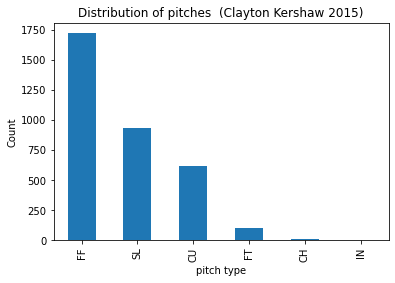

In [39]:
Kershaw2015.pitch_type.value_counts().plot(kind='bar')
plt.xlabel('pitch type')
plt.ylabel('Count')
plt.title('Distribution of pitches  (Clayton Kershaw 2015)')
#plt.plot()

## Get pitches in different counts

    #Code task 16#
    #Create a seaborn boxplot of the ticket price dataframe we created above,
    #with 'state' on the x-axis, 'Price' as the y-value, and a hue that indicates 'Ticket'
    #This will use boxplot's x, y, hue, and data arguments.
    plt.subplots(figsize=(12, 8))
    sns.boxplot(x='state', y='Price', hue='Ticket', data=ticket_prices)
    plt.xticks(rotation='vertical')
    plt.ylabel('Price ($)')
    plt.xlabel('State');

In [67]:
#pitch thrown in each count for righties and lefties. 
possible_counts = [(x,y) for x in range(4) for y in range(3)]
print(possible_counts)


[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]


    bs = zip(kersh2015.loc[:,['b_count']], kersh2015.loc[:,['s_count']])

    BS = kersh2015.groupby(by=['b_count','s_count'])

    BS.plot()

    profile1 = ProfileReport(kersh2015, minimal=True)
    
    #profile1.to_file(output_file="output1_min.html")
    profile1.to_file("output.html")

    kershR2015.pitch_type.value_counts().plot(kind='bar')
    plt.xlabel('pitch type')
    plt.ylabel('Count')
    plt.title('Distribution of pitches against right handed hitters (Clayton Kershaw 2015)')
    #plt.plot()

Pitch Type Definitions
CH - Changeup

CU - Curveball

EP - Eephus*

FC - Cutter

FF - Four-seam Fastball

FO - Pitchout (also PO)*

FS - Splitter

FT - Two-seam Fastball

IN - Intentional ball

KC - Knuckle curve

KN - Knuckeball

PO - Pitchout (also FO)*

SC - Screwball*

SI - Sinker

SL - Slider

UN - Unknown*

these pitch types occur rarely
Code Definitions #
While these aren't spelled out anywhere, play descriptions allowed confident identification of these codes

B - Ball

*B - Ball in dirt

S - Swinging Strike

C - Called Strike

F - Foul

T - Foul Tip

L - Foul Bunt

I - Intentional Ball

W - Swinging Strike (Blocked)

M - Missed Bunt

P - Pitchout

Q - Swinging pitchout

R - Foul pitchout

Values that only occur on last pitch of at-bat:

X - In play, out(s)

D - In play, no out

E - In play, runs

H - Hit by pitch

Note: all codes, except for H, come directly from the XML files. All at-bats with code H were given no code in the XMLs.